In [1]:
'''

This notebook performs feature selection towards the emplyee turnover dataset

'''
import random
import pickle
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, MultinomialNB
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error, r2_score
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from math import sqrt
import seaborn as sns

from joblib import dump
from collections import Counter

In [2]:
# Read preprocessed data
df = pd.read_csv('../preprocessed_data/p_train.csv')
st = pd.read_csv('../preprocessed_data/PerStatus.csv')

# Concat PerStatus to the main train data
data = df.T.append(st.T).T

/var/folders/p1/jtrqrk8964n_9ppqllxb9m280000gn/T/ipykernel_92515/240035390.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df.T.append(st.T).T


In [3]:
# Generate X and Y
X = df.iloc[:, :df.shape[1]]
Y = st.iloc[:,0]

In [4]:
# Make pipeline of classsifier
clf_pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.9450389105058365
Recall score: 0.01256281407035176
Fbeta score: 0.01799557032115172


# Filter Features by Variance

In [5]:
# Print features that has variance lower than thresh
var_thresh = 0.75
var = df.var()
idx = []
for i in range(len(var)):
    if var[i] < var_thresh:
        print('{:50} {}'.format(var.index[i], var[i]))
        idx.append(var.index[i])

sex                                                0.20977519706996783
Job classification                                 0.09741209233474585
Work experience1                                   0.028267770616161987
Work experience2                                   0.04946226756277056
Work experience3                                   0.056616660310785785
Work experience4                                   0.053117377071064065
Work experience5                                   0.17650466644487714
Promotion or Not                                   0.06585434221383735
leave this three mon. B                            0.14219320340607236
leave this year B                                  0.2533759219841596
Business Trip B                                    0.3796519601895895
Marital Status                                     0.19452168645487425
Average working years                              0.5833913783045416
highest education                                  0.0971883135686875


In [6]:
# Drop features that has varaiance lower tahn thresh
print(X.shape)
X_after_variance_filter = X.drop(columns=idx)
print(X_after_variance_filter.shape)

(14392, 46)
(14392, 32)


In [7]:
# See the results after filtering variance
y_pred = cross_val_predict(clf_pipeline, X_after_variance_filter, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.9447609783212896
Recall score: 0.007537688442211055
Fbeta score: 0.010821309655937847


# Filter Features by Correlation

In [8]:
# Check the mean of correlation between featrues and PerStatus
abs(data.corr()['PerStatus']).mean()

0.05530186176962964

In [9]:
# Check all thresh for correlation filter
vals = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
for val in vals:
    features = abs(data.corr()['PerStatus'][abs(data.corr()['PerStatus']) > val].drop('PerStatus')).index.tolist()
    
    testc = data.drop(columns='PerStatus')
    testc = X[features]
    
    print(features)
    
    y_pred = cross_val_predict(clf_pipeline, testc, Y, cv=10)
    print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
    print('Recall score:', metrics.recall_score(Y, y_pred))
    print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

['yyyy', 'sex', 'Job classification', 'Job level', 'Work experience1', 'Work experience3', 'Work experience4', 'Work experience5', 'Project Hours', 'Project Numbers', 'Current project position', 'Special project', 'Training hours A', 'Training hours B', 'Training hours C', 'Number of Honors', 'Promotion speed', 'leave this three mon. A', 'leave this year A', 'leave this three mon. B', 'leave this year B', 'Business Trip A', 'Business Trip B', 'B-Trip Concentration', 'Annual performance C', 'Age level', 'Marital Status', 'Job tenure level A', 'Job tenure level B', 'Job tenure level C', 'Average working years', 'highest education', 'Graduated School', 'Graduated Department', 'Family numbers', 'Work Overtime']
Accuracy score: 0.9447609783212896
Recall score: 0.00628140703517588
Fbeta score: 0.009027777777777779
['yyyy', 'sex', 'Job classification', 'Job level', 'Work experience1', 'Work experience5', 'Project Hours', 'Project Numbers', 'Special project', 'Training hours B', 'Training hour

In [10]:
X_after_correlation_filter = X[['sex', 'Job classification', 'Work experience5', 'Special project', 'Training hours C', 'Promotion speed', 'leave this year A', 'leave this three mon. B', 'leave this year B', 'Age level', 'Marital Status', 'Job tenure level A', 'Job tenure level B', 'Average working years', 'Family numbers']]

# Sequential Feature Selector

In [14]:
X.shape

(14392, 15)

In [ ]:
# Performce SFS
sfsl = SFS(clf_pipeline, 
           k_features = 15, 
           forward=True, 
           scoring='accuracy', 
           cv=10)

sfsl.fit(X, Y)
sfsl.subsets_

In [31]:
X

Work experience5  Promotion speed  Age level  Marital Status  \
0                   0.0              1.0        6.0             1.0   
1                   0.0              1.0        7.0             1.0   
2                   0.0              1.0        7.0             1.0   
3                   0.0              2.0        7.0             1.0   
4                   0.0              6.0        9.0             1.0   
...                 ...              ...        ...             ...   
14387               0.0              5.0       10.0             1.0   
14388               0.0              5.0       10.0             1.0   
14389               0.0              5.0       11.0             1.0   
14390               0.0              5.0       11.0             1.0   
14391               0.0              1.0       11.0             1.0   

       Job tenure level A  Job tenure level B  Family numbers  
0                     2.0                 1.0             0.0  
1                     2.0                 2.0             2.0  
2                     2.0                 2.0             2.0  
3                     2.0                 2.0             2.0  
4                     5.0                 5.0             2.0  
...                   ...                 ...             ...  
14387                 6.0                 5.0             2.0  
14388                 6.0                 5.0             2.0  
14389                 7.0                 6.0             2.0  
14390                 7.0                 6.0             2.0  
14391                 6.0                 1.0             0.0  

[14392 rows x 7 columns]

In [34]:
selected = X

y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.9371178432462479
RMSE: 0.25
R_squared: -0.2
Recall score: 0.00628140703517588
Fbeta score: 0.008507853403141362


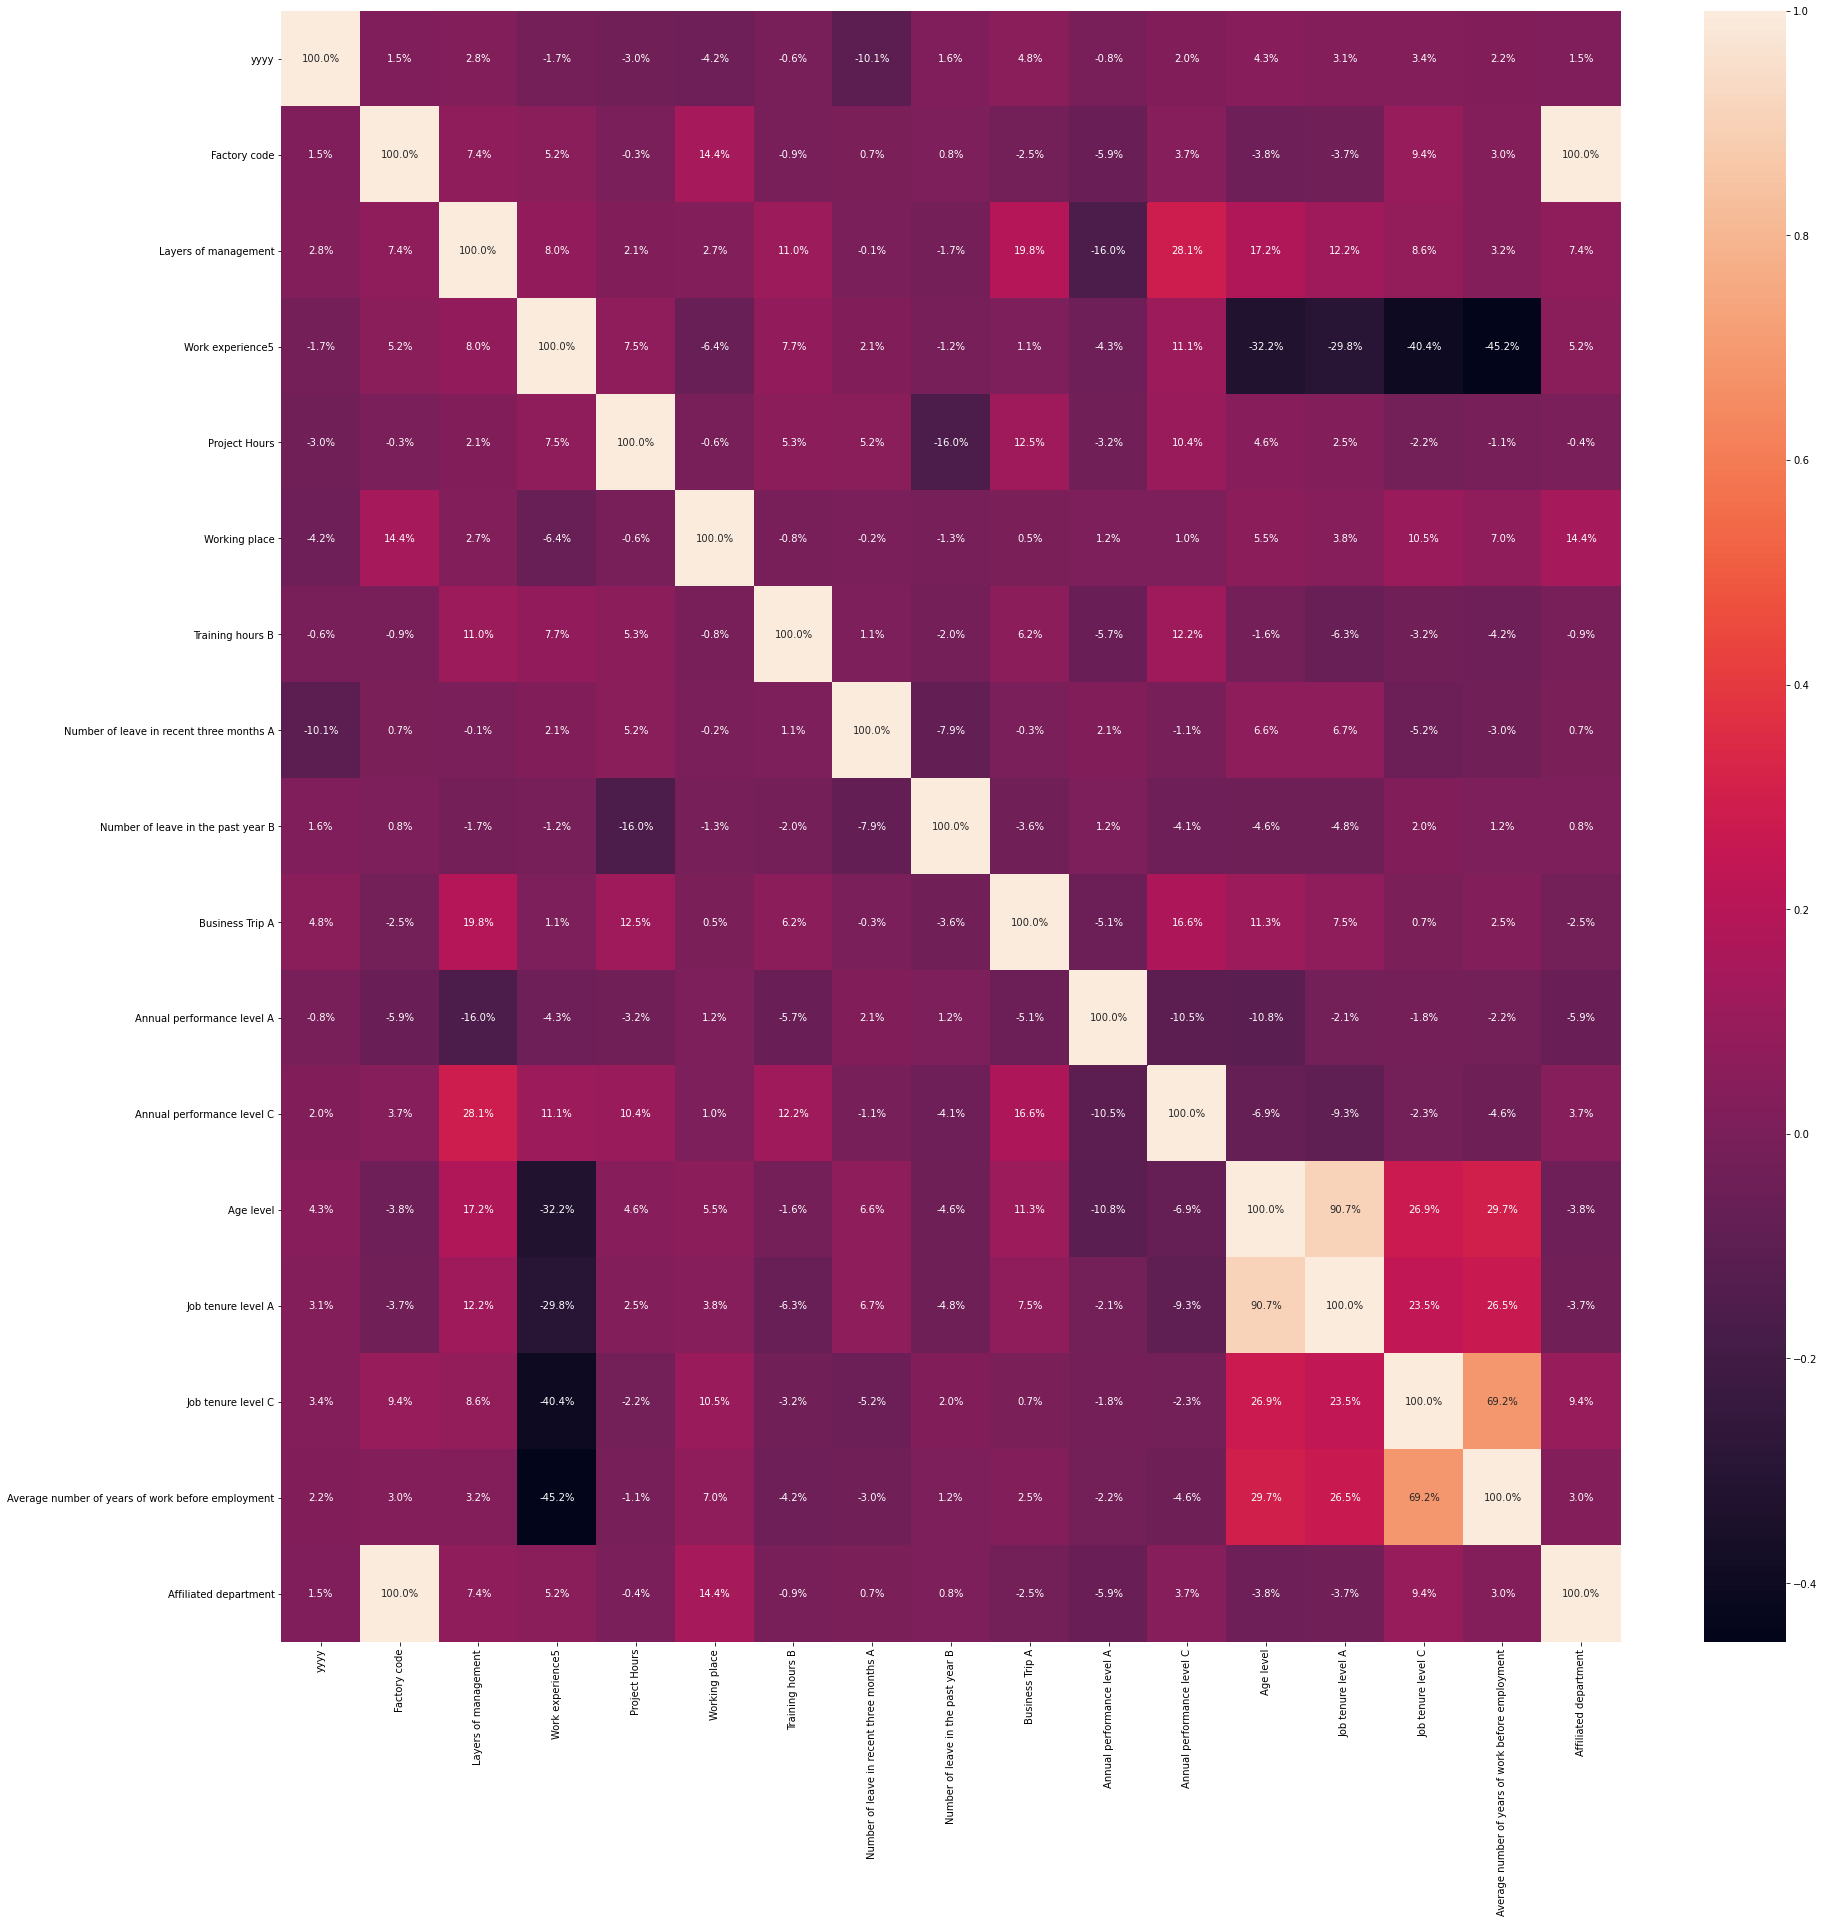

In [159]:
plt.figure(figsize=(30, 30))
sns.heatmap(X[['yyyy', 'Factory code', 'Layers of management', 'Work experience5', 'Project Hours',
              'Working place', 'Training hours B', 'Number of leave in recent three months A', 
              'Number of leave in the past year B', 'Business Trip A', 'Annual performance level A',
              'Annual performance level C', 'Age level', 'Job tenure level A', 'Job tenure level C',
              'Average number of years of work before employment', 'Affiliated department']].corr(), 
             annot=True, fmt='.1%')

In [ ]:
X['AD*FC'] = X['Affiliated department']*X['Factory code']
X['Al*JTA'] = X['Age level']*X['Job tenure level A']

In [46]:
selected = X

y_pred = cross_val_predict(clf_pipeline, X, Y, cv=10)
print('Accuracy score:', metrics.accuracy_score(Y, y_pred))
print('Recall score:', metrics.recall_score(Y, y_pred))
print('Fbeta score:', fbeta_score(Y, y_pred, beta=1.5))

Accuracy score: 0.9202173913043479
RMSE: 0.28
R_squared: 0.44
Recall score: 0.6859296482412061
Fbeta score: 0.7231051344743277


# Training

In [35]:
# Train with feature selected
selected = X

# Scaling
scaler = StandardScaler()
scaler.fit(selected)
selected = scaler.transform(selected)
print(selected)

# Splitting trainset
x_train, x_test, y_train, y_test = train_test_split(selected, Y, test_size=0.2)

# Classifier
model = ExtraTreesClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5)

# Cross_val_score(fbeta)
scoring = cross_val_score(model, selected, Y, cv=10, 
                         scoring=metrics.make_scorer(fbeta_score, beta=1.5))
print('Cross_val_score(mean):', scoring.mean())
print('Corss_val_score(std):', scoring.std())

# Fitting trainset
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Showing Score
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))
print('fbeta:', metrics.fbeta_score(y_test, y_pred, beta=1.5))

[[-0.54480293 -0.94521083 -0.49233084 ... -0.91631238 -1.18370647
  -1.16265225]
 [-0.54480293 -0.94521083 -0.12673436 ... -0.91631238 -0.61969708
   1.00524192]
 [-0.54480293 -0.94521083 -0.12673436 ... -0.91631238 -0.61969708
   1.00524192]
 ...
 [-0.54480293  1.56708877  1.33565157 ...  1.91145325  1.63634046
   1.00524192]
 [-0.54480293  1.56708877  1.33565157 ...  1.91145325  1.63634046
   1.00524192]
 [-0.54480293 -0.94521083  1.33565157 ...  1.34590012 -1.18370647
  -1.16265225]]
Cross_val_score(mean): 0.0
Corss_val_score(std): 0.0
Accuracy: 0.9454671761028135
Recall: 0.0
fbeta: 0.0


In [36]:
# Print out testing results
print('Macro-average: {0}'.format(metrics.f1_score(y_test, y_pred, average='macro')))
print('Micro-average: {0}'.format(metrics.f1_score(y_test, y_pred, average='micro')))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy*100))

print('\n')
print('precision:', metrics.precision_score(y_test, y_pred))
print('recall:', metrics.recall_score(y_test, y_pred))

print('Average = macro')
print('precision:', metrics.precision_score(y_test, y_pred, average='macro'))
print('recall:', metrics.recall_score(y_test, y_pred, average='macro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='macro'))

print('\n')
print('Average = micro')
print('precision:', metrics.precision_score(y_test, y_pred, average='micro'))
print('recall:', metrics.recall_score(y_test, y_pred, average='micro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='micro'))

print('\n')
print('Average = weighted')
print('precision:', metrics.precision_score(y_test, y_pred, average='weighted'))
print('recall:', metrics.recall_score(y_test, y_pred, average='micro'))
print('F1-score:', metrics.f1_score(y_test, y_pred, average='weighted'))

print('\n')
print('Fbeta score:', metrics.fbeta_score(y_test, y_pred, beta=1.5))
print('F1-score:', metrics.f1_score(y_test, y_pred))

Macro-average: 0.4859846455990002
Micro-average: 0.9454671761028135
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2722
           1       0.00      0.00      0.00       157

    accuracy                           0.95      2879
   macro avg       0.47      0.50      0.49      2879
weighted avg       0.89      0.95      0.92      2879

[[2722    0]
 [ 157    0]]
Accuracy: 94.55%


precision: 0.0
recall: 0.0
Average = macro
precision: 0.47273358805140675
recall: 0.5
F1-score: 0.4859846455990002


Average = micro
precision: 0.9454671761028135
recall: 0.9454671761028135
F1-score: 0.9454671761028135


Average = weighted
precision: 0.8939081810878285
recall: 0.9454671761028135
F1-score: 0.9189650610076265


Fbeta score: 0.0
F1-score: 0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# Dump trained models
dump(model, 'last_ext_tunned.joblib')

['last_ext_tunned.joblib']

In [67]:
X

yyyy  sex  Job classification  Job level  Factory code  \
0     2017  1.0                 1.0        4.0          20.0   
1     2017  1.0                 1.0        2.0           8.0   
2     2017  1.0                 1.0        7.0          14.0   
3     2017  1.0                 1.0        3.0           4.0   
4     2017  1.0                 1.0        7.0          13.0   
...    ...  ...                 ...        ...           ...   
4595  2014  1.0                 1.0        4.0          13.0   
4596  2014  1.0                 1.0        3.0          19.0   
4597  2017  0.0                 2.0        7.0          13.0   
4598  2017  1.0                 1.0        7.0          13.0   
4599  2015  0.0                 2.0        4.0           2.0   

      Layers of management  Work experience1  Work experience2  \
0                      1.0               0.0               0.0   
1                      6.0               0.0               0.0   
2                      1.0               0.0               0.0   
3                      4.0               0.0               0.0   
4                      1.0               0.0               0.0   
...                    ...               ...               ...   
4595                   1.0               0.0               0.0   
4596                   4.0               0.0               1.0   
4597                   1.0               0.0               0.0   
4598                   1.0               0.0               1.0   
4599                   1.0               1.0               0.0   

      Work experience3  Work experience4  ...  Job tenure level A  \
0                  0.0               0.0  ...                 2.0   
1                  0.0               0.0  ...                 5.0   
2                  0.0               0.0  ...                 3.0   
3                  0.0               0.0  ...                 6.0   
4                  0.0               0.0  ...                 7.0   
...                ...               ...  ...                 ...   
4595               0.0               0.0  ...                 7.0   
4596               0.0               0.0  ...                 3.0   
4597               0.0               0.0  ...                 2.0   
4598               0.0               0.0  ...                 1.0   
4599               0.0               0.0  ...                 2.0   

      Job tenure level B  Job tenure level C  \
0                    2.0                 0.0   
1                    4.0                 1.0   
2                    3.0                 0.0   
3                    4.0                 4.0   
4                    7.0                 1.0   
...                  ...                 ...   
4595                 7.0                 0.0   
4596                 1.0                 4.0   
4597                 1.0                 2.0   
4598                 1.0                 1.0   
4599                 2.0                 1.0   

      Average number of years of work before employment  \
0                                                   1.0   
1                                                   1.0   
2                                                   0.0   
3                                                   2.0   
4                                                   1.0   
...                                                 ...   
4595                                                1.0   
4596                                                2.0   
4597                                                1.0   
4598                                                1.0   
4599                                                1.0   

      highest education level  Graduated School category  \
0                         2.0                        4.0   
1                         3.0                        1.0   
2                         2.0                        3.0   
3                         2.0                        3.0   
4                         3.0